# Anomaly Detection Proof of Concept

##### Author: AbdAllah Elsheikh

Date: March 9, 2021  
Credit: scikit-learn Anomaly Detection Examples

#### Formulate the problem - Unsupervised Anomaly Detection
What is Anomaly Detection and how "Fairwarning Alerts" problem can be formulated (Supervised, Unsupervised, Semi-Supervised)

-----
Anomaly detection is the ability to detect whether a specific observation belongs to the same distribution of the existing observations. Examples for anomalous observations are fraudelant transactions, structural problems, or medical errors. There are three main approaches for anomaly detection:
1.   **Unsupervised (Outlier detection)**: Detecting anomalies in unlabeled dataset that contain a mix of "Normal/Inliers" and "Abnormal/Outliers" observations, under the assumption that the majority of observations are "Normal". Outliers can be detected based on how close they are to the majority of observations.
2. **Supervised anomaly detection**: This approach requires the dataset to be labeled as "Normal" and "Abnormal". A classifier then learns to distinguish between the two based on different features.
3. **Semi-supervised (Novelty detection)**: In this approach the training data contains "Normal" observations. The training data is used to construct a model to represent "Normal" behavior. When the trained model cannot identify a new/novel observation, it is flagged as an anomaly.

In [1]:
# install sklearn
!pip install sklearn

  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1321 sha256=9099b82ef7167b116e274292cf6aa3be0efdaced4a5541db4e671ceb6f7fc1ef
  Stored in directory: c:\users\abdallahelsheikh\appdata\local\pip\cache\wheels\22\0b\40\fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

In [28]:
# read the dataset
pocDataset = pd.read_csv("AnomalyDataset.csv")
pocDataset = pocDataset.drop(pocDataset.columns[0], axis=1)
pocDataset.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754


In [29]:
# dataset shape
pocDataset.shape

(1000, 10)

#### Split the dataset into Modeling and Unseen
This is to simulate and real life example. This is not the test/split typically used for classification

In [30]:
modelData = pocDataset.sample(frac=0.95, random_state=786)
unseenData = pocDataset.drop(modelData.index)

modelData.reset_index(drop=True, inplace=True)
unseenData.reset_index(drop=True, inplace=True)

print("Data for Modeling:", modelData.shape)
print("Unseen data for Prediction:", unseenData.shape)

Data for Modeling: (950, 10)
Unseen data for Prediction: (50, 10)


#### Construct the model

In [98]:
# Isolation Forest model initialized with default parameters
isolationForestModel = IsolationForest(n_estimators=100, max_samples='auto', contamination=float(0.05))

In [99]:
# print the model
print(isolationForestModel.get_params())

{'behaviour': 'deprecated', 'bootstrap': False, 'contamination': 0.05, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 100, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [100]:
# Fit the model
isolationForestModel.fit(modelData)

IsolationForest(contamination=0.05)

In [101]:
# Predict anomlay labels/Scores for Model Data and Unseen Data ('-1' for outliers and '1' for inliers)
pocDataPred = pd.DataFrame(isolationForestModel.predict(pocDataset), columns=['Anomaly Label'])
pocDataAnomalyScores = pd.DataFrame(isolationForestModel.score_samples(pocDataset), columns=['Anomaly Score'])
pocDataLabeled = pd.concat([pocDataset, (pocDataPred), (pocDataAnomalyScores)], axis=1)

# sklearn changed to reflect anomaly when it's '1' and '0' if is's normal
pocDataLabeled['Anomaly Label'] = np.where(pocDataLabeled['Anomaly Label']==-1,1,0)
pocDataLabeled.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Anomaly Label,Anomaly Score
0,0.263995,0.764929,0.138424,0.935242,0.605867,0.518790,0.912225,0.608234,0.723782,0.733591,0,-0.526679
1,0.546092,0.653975,0.065575,0.227772,0.845269,0.837066,0.272379,0.331679,0.429297,0.367422,0,-0.478865
2,0.336714,0.538842,0.192801,0.553563,0.074515,0.332993,0.365792,0.861309,0.899017,0.088600,1,-0.574125
3,0.092108,0.995017,0.014465,0.176371,0.241530,0.514724,0.562208,0.158963,0.073715,0.208463,1,-0.608483
4,0.325261,0.805968,0.957033,0.331665,0.307923,0.355315,0.501899,0.558449,0.885169,0.182754,0,-0.532589


In [105]:
# Check the number of anomalies
print(pocDataLabeled['Anomaly Label'].value_counts())
outliers = pocDataLabeled.loc[pocDataLabeled['Anomaly Label']==1]
outliersIndices = list(outliers.index)

0    952
1     48
Name: Anomaly Label, dtype: int64


#### Visualize the results of anomaly detection...
Normalize and Reduce dimensions to plot in 3 dimensions then 2

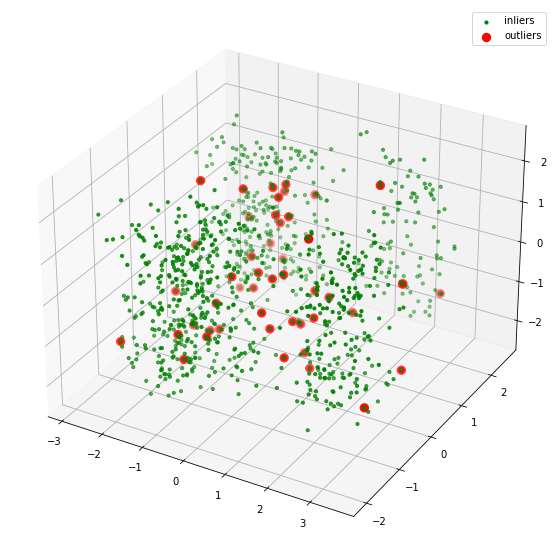

In [147]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
# Dimensions to be reduced to 3
pca = PCA(n_components=3)
scaler = StandardScaler()
# Normalize & Reduce dimensions
X = scaler.fit_transform(pocDataset)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(10,10))
subPlot = fig.add_subplot(projection='3d')
# Plot the compressed data points
subPlot.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=10, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
subPlot.scatter(X_reduce[outliersIndices,0],X_reduce[outliersIndices,1], X_reduce[outliersIndices,2],
           lw=3, s=40, c="red", label="outliers")
subPlot.legend()
plt.show()

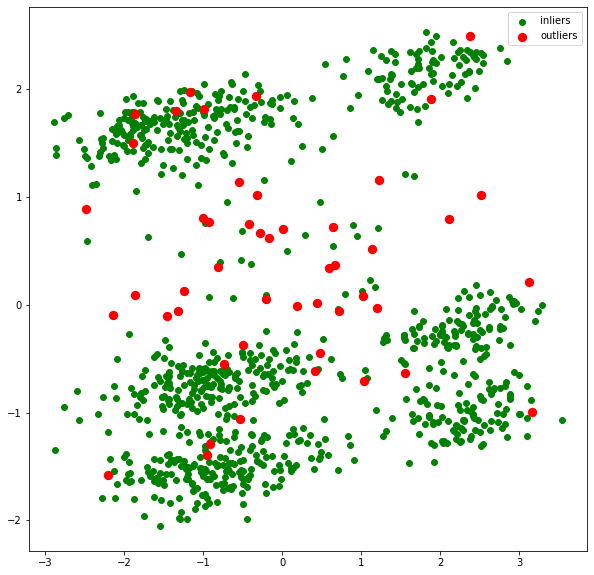

In [144]:
# Dimensions to be reduced to 2
pca = PCA(n_components=2)
scaler = StandardScaler()
# Normalize & Reduce dimensions
X = scaler.fit_transform(pocDataset)
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(10,10))
subPlot = fig.add_subplot()
# Plot the compressed data points
subPlot.scatter(X_reduce[:, 0], X_reduce[:, 1], s=35, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
subPlot.scatter(X_reduce[outliersIndices,0],X_reduce[outliersIndices,1],
           lw=3, s=40, c="red", label="outliers")
subPlot.legend()
plt.show()